## Softmax

Обобщение логистической функции для многомерного случая. Функция преобразует вектор $z$ размерности $K$ в вектор $\sigma$ той же размерности, где каждая координата $\sigma_i$ полученного вектора представлена вещественным числом в интервале $[0,1]$ и сумма координат равна 1.

Координаты $\sigma_i$ вычисляются следующим образом:


${\displaystyle \sigma (z)_{i}={\frac {e^{z_{i}}}{\displaystyle \sum _{k\mathop {=} 1}^{K}e^{z_{k}}}}}$

1. Реализуйте функцию softmax, которая на вход принимает вектор $z$, а на выходе считает от него софтмакс.
2. Добавьте возможность принимать на вход матрицу и считать softmax по столбцам (батч)

In [1]:
import numpy as np

def SoftMax(z): 
    # -*- coding: utf-8 -*-
    """
    This function evaluates softmax function on each column of input array

    Attributes:
        z (array-like): N x M dimentional array of numbers.
    """
    
    
    # Convert data to numpy
    try:
        z = np.array(z)
    except ValueError:
        print('Input data cannot be used for calculation')
        return None
    
    # Return NONE for non-numerical data
    if ('float' not in str(z.dtype) ) and ('int' not in str(z.dtype) ):
        print('dtype error: Input data cannot be used for calculation')
        return None 
    
    # Return NONE for arrays with size more than 2
    if len(z.shape)>2:
        print('shape error: Input data do not fit required shape for calculation. Please, check the size of your input.')
        return None  
    
    # Define whether z is matrix or not. If not - convert N dimentional array to N x 1 array    
    try:
        rows = z.shape[0]
        cols = z.shape[1]
    except IndexError:
        z = np.transpose( np.array(z,ndmin=2) )
        rows = z.shape[0]
        cols = z.shape[1]
        
    # Define output and fill it with 0 values    
    sigma = np.zeros(z.shape)    
    
    # Exponentiate all elements in z
    z = np.exp(z)
    
    # Loop over columns
    for t in range(cols):
        sigma[:,t] = z[:,t]/ np.sum(z[:,t])
        
    # Return result 
    return sigma 

In [2]:
print('====================================================================================')
print('======== Demo ======================================================================')
print('====================================================================================')
print('Result for NxM matrix of numbers:\n',SoftMax([[0,1.0,1],[1,2,2],[1,5,7]]),"\n")
print('Result for Nx1 matrix of numbers:\n',SoftMax([0,1,1]),"\n")
print('Result for Nx1 matrix of strings:\n',SoftMax(['0','1',1]),"\n")
print('Result for KxNxM matrix:\n',SoftMax(np.zeros(shape=[10,10,10])),"\n")
print('====================================================================================')

======== Demo ======================================================================
Result for NxM matrix of numbers:
 [[ 0.1553624   0.01714783  0.00245611]
 [ 0.4223188   0.04661262  0.00667641]
 [ 0.4223188   0.93623955  0.99086747]] 

Result for Nx1 matrix of numbers:
 [[ 0.1553624]
 [ 0.4223188]
 [ 0.4223188]] 

dtype error: Input data cannot be used for calculation
Result for Nx1 matrix of strings:
 None 

shape error: Input data do not fit required shape for calculation. Please, check the size of your input.
Result for KxNxM matrix:
 None 



## Дивергенция Кульбака-Лейблера

* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* ~~Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$~~. 

# Вывод
По определению:
$$D_{KL}(P(x)||Q(x))  = \int_X P(x) \cdot log\left(\frac{P(x)}{Q(x)}\right) dx$$

Так как x - случайная величина, то случайно и отношение $$Y = \frac{Q(x)}{P(x)}$$
Таким образом, выражение для дивергенции принимает следующий вид:
$$D_{KL}(P(x)||Q(x))  = \int_X P(x) \cdot -log\left(Y\right) d\mu = \int_X P(x) \cdot \phi\left(Y\right) d\mu = E \left[\phi(Y)\right]$$

По формуле Йенсена для случайной величины Y и выпуклой функции $\phi(y)$ выполнено неравенство:   $$ E ⁡ [ φ ( Y ) ] ≥ φ ( E ⁡ [ Y ] ) $$
Тогда:
$$ D_{KL}(P(x)||Q(x)) ≥ -log\left(E\left[\frac{Q(x)}{P(x)}\right]\right) = - log\left(\int_X Q(x)dx\right) = -log(1) = 0$$
Доказано, что:
$$ D_{KL}(P(x)||Q(x)) ≥ 0 $$

## Обучение линейных моделей

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [3]:
import numpy as np
from keras.datasets import cifar10  
from random import randrange
import time

Using TensorFlow backend.
/home/cardif/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [5]:
# Тут пришлось погеморроиться. Почему-то у меня на ноуте метод cifar10.load_data вообще не работал. 
## Запускался и работал бесконечно долго. Ну, я как бы переписал его вручную :)
import os
from keras import backend as K
def load_data(PathToBatches):
    """Loads CIFAR10 dataset.

    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = PathToBatches

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = PathToBatches + '/data_batch_' + str(i)
        data, labels = cifar10.load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(PathToBatches+'/test_batch')
    x_test, y_test = cifar10.load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)
(x_train, y_train),(x_test, y_test) = load_data('/windows/Users/CARDIF/Downloads/cifar-10-python/cifar-10-batches-py')
print('Train data shape',x_train.shape)
print('Test data shape',x_test.shape)

Train data shape (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)


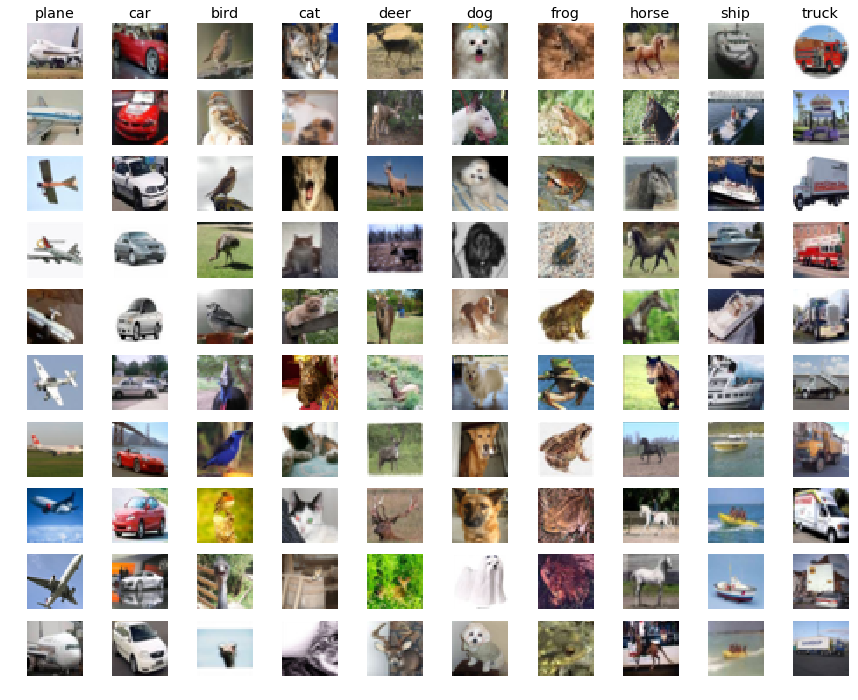

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


In [7]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[ 130.71074  136.05614  132.5538   130.14036  135.44238  131.85358
  131.05044  136.24616  132.58144  131.56886]


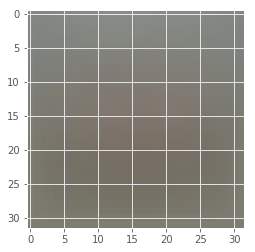

In [8]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [9]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
for i in x_train:
    i = i - mean_image
for i in x_test:
    i = i - mean_image

In [10]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [11]:
# 4: Перед реализацией svm_loss напечатаем на экран размерности входных и выходных массивов
print('x_train.shape',x_train.shape)
print('x_test.shape',x_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

x_train.shape (50000, 3073)
x_test.shape (10000, 3073)
y_train.shape (50000, 1)
y_test.shape (10000, 1)


**Задача 1:** Далее следует функция svm_loss, которую вам предстоит дописать.

**Решение:** 

Пусть объект $\vec{x}$ описывается вектором признаков длины M. $k = \overline{1,M}$.

Пусть количество объектов в выборке равно N. $i = \overline{1,N}$.

Матрица объект - признак имеет размерность $X_{NxM}$

Решается задача классификации на $N_{classes}$ классов $j = \overline{1,N_{classes}}$. 

Это задача Supervised Learning с обучением классификации на $N_{classes}$ классов на обучающей выборке длины $N$ объектов, описываемых $M$ признаками.
Обучение производится путём минимизации функции потерь (Loss Function) $L(x)$ алгоритма на объектах обучающей выборки.

Hinge Loss (или, иначе, Multiclass SVM loss) на объекте $\vec{x_i}$ с значением истинного класса $y_i \in \{1,..,N_{classes}\}$  это сумма отступов скора классификатора для неправильных классов от скора классификатора для правильного класса для всех тех классов, для которых классификатор присваивает неправильному классу скор больше, чем правильному; для исключения краевых эффектов в Loss добавляется ещё отступ Margin(обозначается буквой $\Delta$):
$$ L_i= L(\vec{x_i}) = \sum_{j\neq y_i}^{N_{classes}} = \max(0; score_j(\vec{x_i}) - score_i(\vec{x_i}) + \Delta)$$

В случае линейного классификатора скор класса $j$ для объекта $\vec{x}$ определяется следующим образом: $$score_j(\vec{x}) = \vec{w_j}^T \cdot \vec{x} + b_j.$$
Здесь $\vec{w_j}$ - вектор весов линейного классификатора для определения класса $j$.  
Функция ошибок Hinge Loss на объекте $\vec{x_i}$ с значением истинного класса, равным $y_i$ для линейного классификатора:
$$ L_i= L(\vec{x_i}) = \sum_{j\neq y_i}^{N_{classes}} \max(0; \vec{w_j}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta)$$
$$ L_i= L(\vec{x_i}) = \sum_{j\neq y_i}^{N_{classes}} \max\left(0; \sum_{k=0}^Mw_{k,j} x_{i,k} - \sum_{k=0}^Mw_{k,{y_i}} x_{i,k} + \Delta\right)$$
Повозившись (минуты 2-3) с производными, легко увидеть, что: 
$$\begin{equation*}
\frac{\partial L_i}{\partial w_{kj}} =
\begin{cases}
   I\left[\max(0; \vec{w_j}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta) > 0\right] \cdot  x_{i,k} &\text{если j $\neq y_i$}\\
   - \sum_{\psi\neq y_i}^{N_{classes}} I\left[\max(0; \vec{w_\psi}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta) > 0\right] \cdot x_{i,k} &\text{если j =$  y_i$}
 \end{cases}
\end{equation*}$$

Здесь $I(\xi)$ обозначает функцию - индикатор, которая равна 1 если $\xi = True$ и 0 в противном случае.

Окей, теперь пора добавить какую-нибудь регуляризацию (штраф модели за слишком большую сложность). Вариантов много, но по заданию нужна регуляризация Тихонова (ограничение на квадратичную норму матрицы весов).

Функция ошибок Hinge Loss на выборке из $N$ объектов для линейного классификатора c регуляризацией Тихонова:
$$ L=  \frac{1}{N}\cdot\sum_{i=1}^N{L(\vec{x_i})}  + \lambda \cdot \sum_i\sum_j w_{i,j}^2$$

Градиент функции ошибок Hinge Loss на выборке из $N$ объектов для линейного классификатора c регуляризацией Тихонова:
$$ \frac{\partial L}{\partial w_{kj}} =
  \frac{1}{N}\cdot\sum_{i=1}^N{\frac{\partial L_i}{\partial w_{kj}}}  + 2\lambda \cdot w_{k,j}$$




# Векторная форма функции ошибок hinge loss

 Функция ошибок Hinge Loss на объекте $\vec{x_i}$ с значением истинного класса, равным $y_i$ для линейного классификатора:
$$ L_i= L(\vec{x_i}) = \sum_{j\neq y_i}^{N_{classes}} \max(0; \vec{w_j}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta)$$
$$ L_i= L(\vec{x_i}) = \max(0; \vec{w_1}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta) + $$
$$                     \max(0; \vec{w_2}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta) + \dots + $$
$$                     \max(0; \vec{w_{N_{classes}}}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta) $$

Производная по всем $\vec{w_k}$, где $k \neq  {y_i}$:
$$\frac{\partial L_i}{\partial \vec{w_k}} = I(\vec{w_k}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta > 0) \cdot \vec{x_i}$$

Для случая, когда $k =  {y_i}$:
$$\frac{\partial L_i}{\partial \vec{w_{y_i}}} = -\sum_{j\neq y_i}^{N_{classes}} I(\vec{w_j}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta > 0) \cdot \vec{x_i}$$

Введём в рассмотрение матрицу $Binary_{i,k},  \text{для которой } i=\overline{1,N}, k = \overline{1,N_{classes}} $, элементы которой будут определяться следующим образом:
$$\begin{equation*}
Binary_{i,k} =
\begin{cases}
   I(\vec{w_k}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta > 0)  &\text{если k $\neq y_i$}\\
   -\sum_{j\neq y_i}^{N_{classes}} I(\vec{w_j}^T \vec{x_i} - \vec{w_{y_i}}^T \vec{x_i} + \Delta > 0) &\text{если k =$  y_i$}
 \end{cases}
\end{equation*}$$

Тогда матрица градиентов $dW$ выражается следующим образом:
$$ dW = \frac{\partial L}{\partial w_{kj}} =
  \frac{1}{N}\cdot\sum_{i=1}^N{\frac{\partial L_i}{\partial w_{kj}}}  + 2\lambda \cdot w_{k,j} =
  \frac{1}{N}\cdot\sum_{i=1}^N{\vec{x_i} \cdot Binary_{i,k}}  + 2\lambda \cdot \vec{w_j}   $$

Если присмотреться, то $\sum_{i=1}^N{\vec{x_i} \cdot Binary_{i,k}}$ это ничто иное, как $X^T \cdot Binary$.

Таким образом, в матричном виде:
$$ dW = \frac{1}{N} \cdot X^T \cdot Binary + 2 \lambda \cdot W$$


In [12]:
def svm_loss(W, X, y, reg):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов (размерности 10x3073)
    - X: Данные (размерности Nx3073)
    - y: Целевой признак, размерность Nx1 (!!!меняется от 0 до 9 и это очень важно!!!)
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    N = len(X) # Number of observations
    (W,X,y) = (np.array(W) , np.array(X) , np.array(y)) # Convert W,X,y to numpy arrays
    Delta = 1 # margin 
    # ============================================================
    loss = np.zeros(shape = N)
    
    Linear_Model_Scores = np.matmul(X,np.transpose(W)) # X * W^t даст матрицу скоров размерности N x 10
    
    Correct_Scores = np.zeros(shape = N) # Вектор длины N, содержащий значения скоров для истинных классов
    Correct_Scores = Linear_Model_Scores[np.arange(N),y[:,0]]
    
    # Тут дальше идёт строчка, содержащая вычитание из матрицы Linear_Model_Scores столбца Correct_Scores 
    # и затем добавления к этому всему поэлементно скаляра Delta.
    # У кодеров C++ тут должен случиться инфаркт, но Питончик всё красиво оформит, он всё это умеет обрабатывать
    
    # p.s. два раза пришлось применять операцию транспонирования, т.к. numpy умеет вычитать вектор из матрицы 
    # только построчно
    Linear_Model_Scores = (Linear_Model_Scores.T - Correct_Scores).T + Delta   
    Linear_Model_Scores[np.arange(N),y[:,0]] = Linear_Model_Scores[np.arange(N),y[:,0]] - Delta    
    Linear_Model_Scores = np.maximum(Linear_Model_Scores,0)
    
    # Далее - Loss это средний loss по всем объектам 
    loss = np.average(np.sum(Linear_Model_Scores,axis=1))
    
    # Добавляем в loss регуляризацию
    loss = loss + reg * np.sum(np.power(W,2))
    # ============================================================
    dW = np.zeros(shape = W.shape) # инициализация матрицы, содержащей градиенты
    binary = np.zeros(shape = Linear_Model_Scores.shape) # Заполнение бинарной матрицы нулями
    binary[Linear_Model_Scores > 0] = 1 # Для всех не равных нулю элементов проставим значение 1
    row_sum = np.sum(binary, axis=1) # просуммируем матрицу вдоль строк. Получим вектор длины N
    binary[np.arange(N), y[:,0]] = -row_sum.T # Проставим в бинарную матрицу полученные суммы на позицию верного класса
    dW = np.matmul(X.T, binary) 
    dW = dW.T  / N + reg*W
    # ============================================================
    return loss, dW

In [ ]:
np.max()

In [13]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss(W, x_test[:1000,:], y_test[:1000], 0)
print('loss: %f' % (loss,))

loss: 10.563245


In [14]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])
        
        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        IsOk =lambda x: 'ok' if x < 0.01 else 'not ok'
        error = round(rel_error,4)
        print ('numerical: %f analytic: %f, relative error: %f, IsOk: %s' % (grad_numerical, grad_analytic, error,IsOk(error) ))

In [15]:
# Вычисляем значение функции потерь и её градиент для W.
print('==========================================================================\n' +
      'Проверка расчёта без регуляризации \n'+
      '==========================================================================\n')
loss, grad = svm_loss(W, x_test, y_test, 0.0)
# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print('==========================================================================\n' +
      'Проверка расчёта с регуляризацией \n'+
      '==========================================================================\n')
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print('=========================================================================================================')


Проверка расчёта без регуляризации 

numerical: 5.856641 analytic: 5.839700, relative error: 0.001400, IsOk: ok
numerical: 25.024433 analytic: 25.032800, relative error: 0.000200, IsOk: ok
numerical: 11.838908 analytic: 11.871300, relative error: 0.001400, IsOk: ok
numerical: -32.597468 analytic: -32.594200, relative error: 0.000100, IsOk: ok
numerical: 21.455432 analytic: 21.462700, relative error: 0.000200, IsOk: ok
numerical: 4.900827 analytic: 4.889100, relative error: 0.001200, IsOk: ok
numerical: -5.095680 analytic: -5.103400, relative error: 0.000800, IsOk: ok
numerical: 27.347791 analytic: 27.335500, relative error: 0.000200, IsOk: ok
numerical: 34.318826 analytic: 34.343900, relative error: 0.000400, IsOk: ok
numerical: 16.585249 analytic: 16.581200, relative error: 0.000100, IsOk: ok
Проверка расчёта с регуляризацией 

numerical: 2.218116 analytic: 2.208106, relative error: 0.002300, IsOk: ok
numerical: 24.389559 analytic: 24.411923, relative error: 0.000500, IsOk: ok
numeric

**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [16]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        self.batch_size = 128
        self.learning_rate=1e-7
        self.reg=2.5e4
        self.num_iters=1000
        
    def fit(self, x_train, y_train, batch_size=128, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        self.learning_rate = learning_rate
        self.reg = reg
        self.num_iters = num_iters
        self.batch_size = batch_size
        
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        N = len(x_train)
        for it in range(num_iters):
            idx = np.random.randint(low =0 , high = N, size=batch_size,dtype='int')
            x = x_train[idx,:]
            y = y_train[idx,:]
            loss,grad = svm_loss(self.W,x,y,reg)
            loss_history.append(loss)
            self.W = self.W-learning_rate*grad

        return loss_history
    
    def get_params(self,deep = True):
        return {'learning_rate':self.learning_rate, 'reg':self.reg}
    
    def predict(self, X):
        Y = np.matmul(X,self.W.T)
        res = np.zeros(Y.shape[0])
        for i,row in enumerate(Y):
            res[i]=np.argmax(row)
        return res

Проверяем полученную реализацию.

In [17]:
tic = time.time()
svm = SVM()
loss_hist = svm.fit(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True,batch_size = 256)
toc = time.time()
print('That took %fs' % (toc - tic))

That took 5.878967s


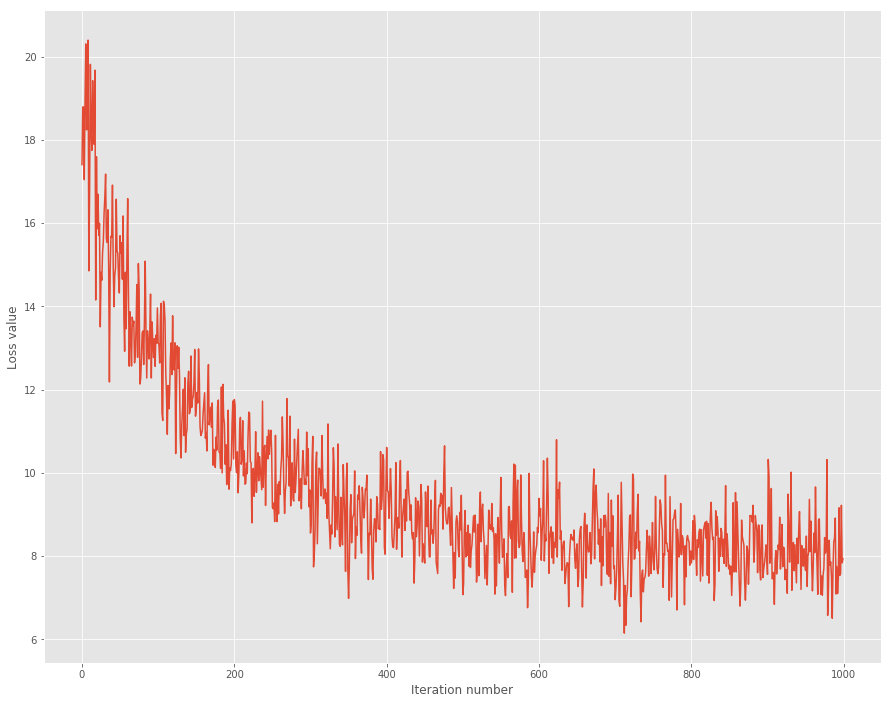

In [18]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
y_test_pred = svm.predict(x_test)
print('training accuracy: %f' % accuracy_score(y_true = y_train,y_pred = y_train_pred, normalize =True) )
print('test accuracy: %f' % accuracy_score(y_true = y_test,y_pred = y_test_pred, normalize =True) )

training accuracy: 0.220080
test accuracy: 0.214300


In [20]:
def plot_weights(best_svm):
    w = best_svm.W[:,:-1] # strip out the bias
    w = w.reshape(10, 32, 32, 3)
    w_min, w_max = np.min(w), np.max(w)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

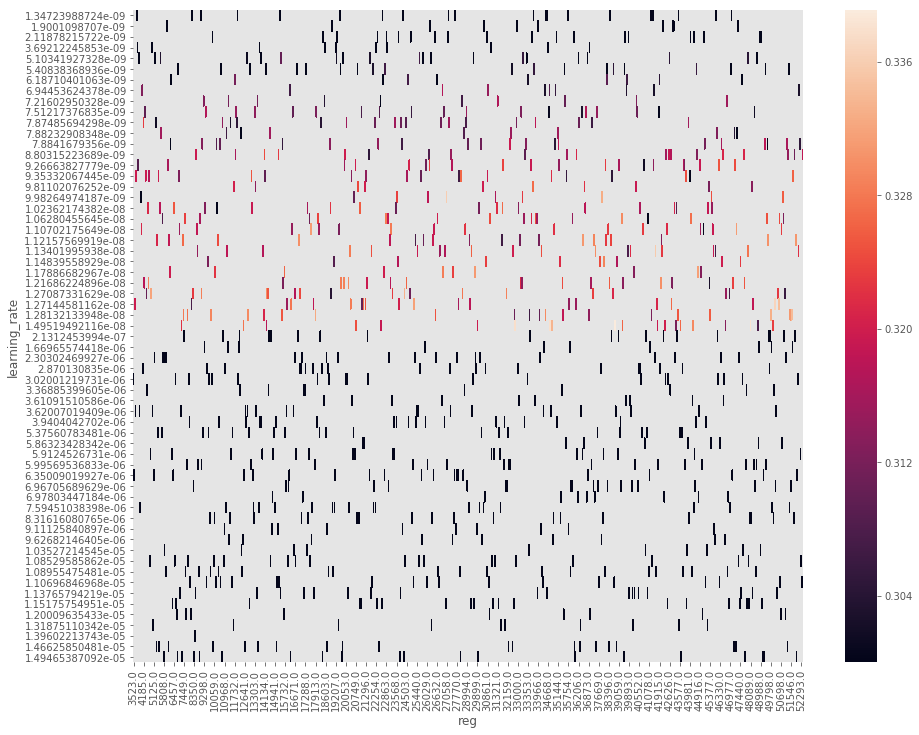

In [21]:
import pandas as pd
import pickle
# Создаем dataframe, куда будем записывать параметры
fit_log = pd.DataFrame(columns = ['learning_rate','reg','train_accuracy','test_accuracy'])
try:
    with open('GridSearch.pickle', 'rb') as f:
        fit_log = pickle.load(f)
except:
    pass
# Определяем функцию, которая бы на вход принимала параметры модели, а на выходе бы давала 
# метрику качества на тренировочном и тестовом наборе данных 
def GridSearch(x_train,y_train,x_test,y_test,learning_rate = 0.01,reg = 0):
    svm= SVM()
    svm.fit(x_train = x_train,y_train = y_train,learning_rate=learning_rate,reg=reg, num_iters=500)
    y_train_pred = svm.predict(x_train)
    y_test_pred = svm.predict(x_test)
    return round(accuracy_score(y_true = y_train,y_pred = y_train_pred, normalize =True),4),\
            round(accuracy_score(y_true = y_test,y_pred = y_test_pred, normalize =True),4) 

# Себе на заметку - добавить сюда параллельные вычисления на всех ядрах.
# Далее тупо пробегаем по циклу, перебирая случайно сгенерированные параметры из равномерного распределения
# На каждой итерации цикла записываем в датафрейм параметры модели и метрики качества на тренировочном и тестовом наборе данных 

# Для воспроизводимости результатов зададим конкретный Seed для случайных чисел
np.random.seed = 65

for l_rate in np.random.uniform(0.1 * 1e-8,1.5 * 1e-5,size=1):
    reg_grid = np.random.randint(0.1 * 3.5e4,1.5 * 3.5e4,size=1)
    for reg in reg_grid:
        acc_train,acc_test = GridSearch(x_train = x_train,y_train=y_train,x_test = x_test,y_test=y_test,learning_rate=l_rate,reg=reg)
        fit_log=fit_log.append({'learning_rate':l_rate,\
                        'reg':int(reg),
                        'train_accuracy':acc_train,
                        'test_accuracy':acc_test},ignore_index = True)
# Запишем в Picke файл результаты поиска
with open('GridSearch.pickle', 'wb') as f:
    pickle.dump(fit_log, f)
# Визуализируем наш GridSearch на HeatMap'е с помощью Seaborn'а    
import seaborn as sns
sns.heatmap(data = fit_log.pivot_table(index = 'learning_rate', columns = 'reg',values ='test_accuracy', aggfunc='mean'),vmin=.30);

best learning rate is  1.49519492116e-08
best regularization parameter is  38899.0
train accuracy is  0.3384
test accuracy is  0.3391


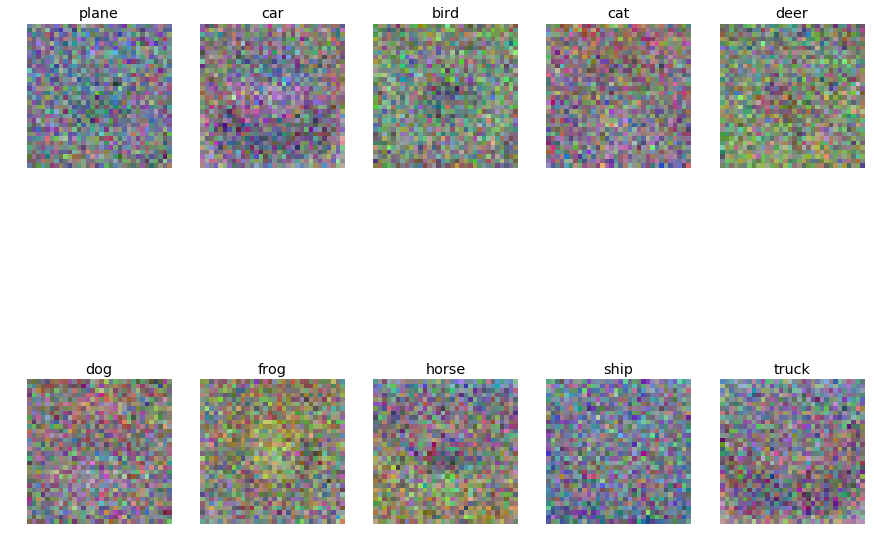

In [22]:
best_result_index = fit_log['test_accuracy'].argmax()
best_result = fit_log.loc[best_result_index]
print('best learning rate is ',best_result['learning_rate'])
print('best regularization parameter is ',best_result['reg'])
print('train accuracy is ',best_result['train_accuracy'])
print('test accuracy is ',best_result['test_accuracy'])
best_svm = SVM()
best_svm.fit(x_train = x_train,y_train = y_train,learning_rate=best_result['learning_rate'],reg=best_result['reg'], num_iters=1000)
plot_weights(best_svm)

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

Полученные изображения прямо говорят
![Выводы](ДЗ1-выводы.jpeg)

Однако, стоит приглядеться к изображению, например, лягушки - видно явное зелёное пятно круглой формы по центру изображения. Это говорит о том, что большая часть изображений, содержащая лягушек, представляла собой лягушку, расположенную по центру изображения и имеющую круглую форму. Аналогичный вывод можно сделать для других изображений - какие-то простейшие паттерны в данных линейный классификатор, складывающий пиксели с весами, всё-таки уловил - будь то черная полоса внизу изображения машины или тёмное пятно в центре от лошади (видимо, грива).

Дополнительно, хотелось бы сказать, что ошибка на Test оказалась чуть меньше, чем на Train. Это, вообще говоря, нонсенс. Однако, дельта очень маленькая и, вероятно, связана с случайностью.

**Задача 5:** Повторим упражнение для cross entropy loss

Идея кросс-энтропийной функции потерь в том, чтобы минимизировать меру расстояния между двумя вероятностными распределениями - истинным $y(x) = (0,0,\dots,0,1,0,\dots,0,0)$ и предсказанным моделью $\hat{y}(x) = (p_1,p_2,\dots,p_{10})$

Пусть объект $\vec{x}$ описывается вектором признаков длины M. $k = \overline{1,M}$.

Пусть количество объектов в выборке равно N. $i = \overline{1,N}$.

Матрица объект - признак имеет размерность $X_{NxM}$

Решается задача классификации на $N_{classes}$ классов $j = \overline{1,N_{classes}}$. 

Это задача Supervised Learning с обучением классификации на $N_{classes}$ классов на обучающей выборке длины $N$ объектов, описываемых $M$ признаками.
Обучение производится путём минимизации функции потерь (Loss Function) $L(x)$ алгоритма на объектах обучающей выборки.

Функция потерь на объекте $\vec{x_i}$ выражается следующим образом: 
$$ L(\vec{x_i}) = H(y,\hat{y}) = - \sum_{j=1}^{N_{classes}} y_j(\vec{x_i})\cdot log(\hat{y_j}(\vec{x_i}))$$

Функция ошибок на выборке из $N$ объектов для линейного классификатора c регуляризацией Тихонова:
$$ L=  \frac{1}{N}\cdot\sum_{i=1}^N{L(\vec{x_i})}  + \lambda \cdot \sum_i\sum_j w_{i,j}^2$$

Градиент функции ошибок на выборке из $N$ объектов для линейного классификатора c регуляризацией Тихонова:
$$ \frac{\partial L}{\partial w_{kj}} =
  \frac{1}{N}\cdot\sum_{i=1}^N{\frac{\partial L_i}{\partial w_{kj}}}  + 2\lambda \cdot w_{k,j}$$,
  где $$\frac{\partial L_i}{\partial w_{kj}} = \left(softmax(\vec{w_k}^T \cdot \vec{x_i}) - p_k\right) \cdot X_{ij}$$



In [134]:
def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
    Inputs:
    - W: Матрица весов (размерности 10x3073)
    - X: Данные (размерности Nx3073)
    - y: Целевой признак, размерность Nx1 (!!!меняется от 0 до 9 и это очень важно!!!)
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    N = X.shape[0] # Number of observations
    M = X.shape[1] # Number of features describing object
    
    (W,X,y) = (np.array(W) , np.array(X) , np.array(y)) # Convert W,X,y to numpy arrays
    # ===========================================================================================================================================================================================   
    Linear_Model_Scores = np.matmul(X,np.transpose(W)) # X * W^t даст матрицу скоров размерности N x 10 
     # Далее - построчно вычитается максимальный скор. Это линейное преобразование, которое ничего не изменит в сущности, но которое позволит избежать численных проблем
    Linear_Model_Scores -= np.max(a=Linear_Model_Scores,axis=1,keepdims = True) 
    q = np.apply_along_axis(func1d = SoftMax,axis = 1, arr = Linear_Model_Scores) # Применим SoftMax, который ранее писали, к каждой строчке матрицы скоров
    q = np.squeeze(a=q,axis = 2) # В результате прошлой строчки кода получится массив размерности (N, N_Classes, 1). Последняя единичка ни к чему. Удалим ось благодаря функции squeeze
    log_q = -np.log(q) # Поэлементное логарифмирование массива q. Халяльно, через оптимизированный код numpy.
    loss = log_q[np.arange(N),y] # Из определения cross entropy loss следует, что loss для каждого объекта - это -ln(q)[правильный класс]    
    loss = np.average(loss) # Далее - Loss по выборке это средний loss по всем объектам выборки    
    loss = loss + reg * np.sum(np.power(W,2))# Добавляем в loss регуляризацию
    # ===========================================================================================================================================================================================
    dW = np.zeros(W.shape)
    CrossEntGradCoeff = q.copy()
    CrossEntGradCoeff[np.arange(N),y[:,0]] -= 1.0 
    dW = np.matmul(np.transpose(CrossEntGradCoeff),X)
    dW = dW  / float(N) + reg*W
    # ===========================================================================================================================================================================================
    return loss, dW

In [142]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001 

# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)

In [137]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))

loss: 2.466420
sanity check: 2.302585


**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

Да все просто. Ошибка в Cross entropy loss представляет собой $-Ln(\text{вероятностная оценка правильного класса моделью})$.

Матрицу весов $W$ в линейной модели мы инициализировали какими-то очень маленькими числами, без какой-либо логики.

Это приводит к тому, что SoftMax выдаёт значения для каждого класса близкие к 10%.

Значит, вероятностная оценка правильного класса моделью - это случайное угадывание нужного класса, т.е. 10%.

Оттуда и близость к -ln(10%)

In [139]:
# Вычисляем значение функции потерь и её градиент для W.
print('==========================================================================\n' +
      'Проверка расчёта без регуляризации \n'+
      '==========================================================================\n')
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)
# Проверяем численно
f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print('==========================================================================\n' +
      'Проверка расчёта с регуляризацией \n'+
      '==========================================================================\n')
loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 0)
print('=========================================================================================================')


Проверка расчёта без регуляризации 

numerical: 0.872913 analytic: -1.702282, relative error: 1.000000, IsOk: not ok
numerical: 0.234975 analytic: -3.577669, relative error: 1.000000, IsOk: not ok
numerical: -2.474384 analytic: -2.786926, relative error: 0.059400, IsOk: not ok
numerical: 0.697925 analytic: -1.368869, relative error: 1.000000, IsOk: not ok
numerical: -3.445057 analytic: -3.586069, relative error: 0.020100, IsOk: not ok
numerical: 3.398337 analytic: 6.779101, relative error: 0.332200, IsOk: not ok
numerical: 1.756672 analytic: 1.729688, relative error: 0.007700, IsOk: ok
numerical: -7.828903 analytic: -7.689164, relative error: 0.009000, IsOk: ok
numerical: 3.512798 analytic: 5.714393, relative error: 0.238600, IsOk: not ok
numerical: 2.188774 analytic: 0.861910, relative error: 0.434900, IsOk: not ok
Проверка расчёта с регуляризацией 



In [155]:
class CrossEntropy():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        self.batch_size = 128
        self.learning_rate=1e-7
        self.reg=2.5e4
        self.num_iters=1000
        
    def fit(self, x_train, y_train, batch_size=128, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        self.learning_rate = learning_rate
        self.reg = reg
        self.num_iters = num_iters
        self.batch_size = batch_size
        
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        N = len(x_train)
        for it in range(num_iters):
            idx = np.random.randint(low =0 , high = N, size=batch_size,dtype='int')
            x = x_train[idx,:]
            y = y_train[idx,:]
            loss,grad = crossentropy_loss(self.W,x,y,reg)
            loss_history.append(loss)
            self.W = self.W-learning_rate*grad

        return loss_history
    
    def get_params(self,deep = True):
        return {'learning_rate':self.learning_rate, 'reg':self.reg}
    
    def predict(self, X):
        Y = np.matmul(X,self.W.T)
        res = np.zeros(Y.shape[0])
        for i,row in enumerate(Y):
            res[i]=np.argmax(row)
        return res

That took 45.019858s


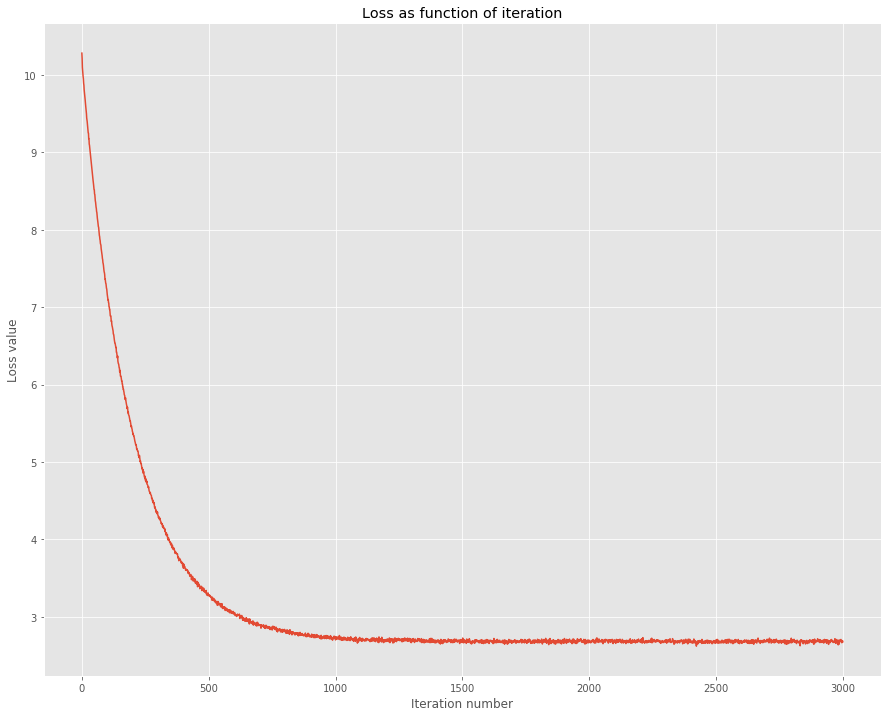

training accuracy: 0.339820
test accuracy: 0.336600


In [159]:
tic = time.time()
crossentropy = CrossEntropy()
loss_hist = crossentropy.fit(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=3000, verbose=True,batch_size = 256)
toc = time.time()
print('That took %fs' % (toc - tic))
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.title('Loss as function of iteration')
plt.show()

from sklearn.metrics import accuracy_score
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = crossentropy.predict(x_train)
y_test_pred = crossentropy.predict(x_test)
print('training accuracy: %f' % accuracy_score(y_true = y_train,y_pred = y_train_pred, normalize =True) )
print('test accuracy: %f' % accuracy_score(y_true = y_test,y_pred = y_test_pred, normalize =True) )

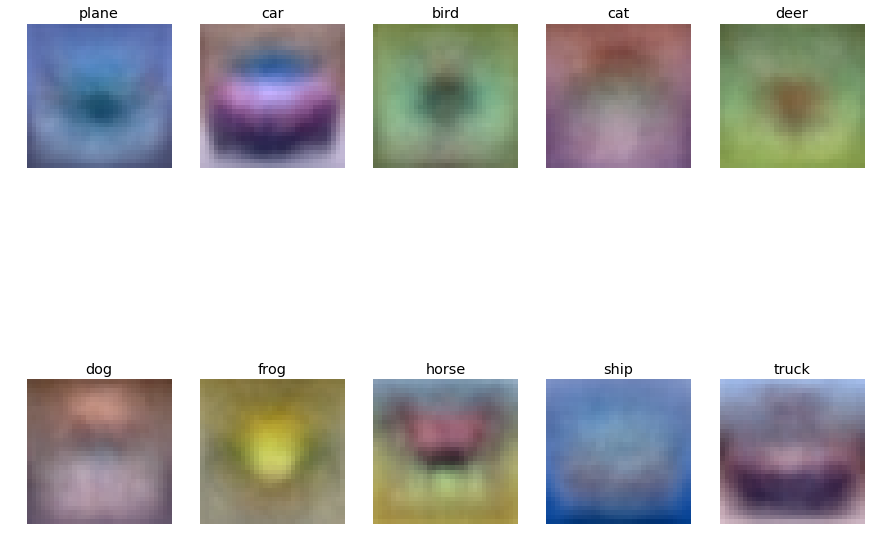

In [160]:
plot_weights(crossentropy)